<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VQA_QAOA(TSP4x4_Numpy)_mkbahk_20260206_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
"""
TSP with QAOA - Simplified Simulation
Qiskit 대신 numpy를 이용한 QAOA 개념 시뮬레이션
"""

'\nTSP with QAOA - Simplified Simulation\nQiskit 대신 numpy를 이용한 QAOA 개념 시뮬레이션\n'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [5]:
# 4x4 거리 행렬 (대칭 행렬)
distance_matrix = np.array([
    [0, 10, 15, 20],
    [10, 0, 35, 25],
    [15, 35, 0, 30],
    [20, 25, 30, 0]
])

print("=" * 60)
print("TSP with QAOA - Simplified Simulation")
print("=" * 60)
print("\nDistance Matrix:")
print(distance_matrix)
print()

n_cities = 4
num_qubits = n_cities * n_cities

TSP with QAOA - Simplified Simulation

Distance Matrix:
[[ 0 10 15 20]
 [10  0 35 25]
 [15 35  0 30]
 [20 25 30  0]]



In [6]:
# TSP를 QUBO로 변환
def create_tsp_qubo(dist_matrix, penalty=100):
    """TSP를 QUBO 문제로 변환"""
    n = len(dist_matrix)
    num_vars = n * n
    Q = np.zeros((num_vars, num_vars))

    def idx(city, position):
        return city * n + position
    ###def

    # 제약조건 1: 각 도시는 정확히 한 번만 방문
    for city in range(n):
        for pos1 in range(n):
            for pos2 in range(n):
                i = idx(city, pos1)
                j = idx(city, pos2)
                if i == j:
                    Q[i][i] += -penalty
                else:
                    Q[i][j] += penalty
                ###if
            ###for
        ###for
    ###for

    # 제약조건 2: 각 위치에서 정확히 한 도시만 방문
    for pos in range(n):
        for city1 in range(n):
            for city2 in range(n):
                i = idx(city1, pos)
                j = idx(city2, pos)
                if i == j:
                    Q[i][i] += -penalty
                else:
                    Q[i][j] += penalty
                ###if
            ###for
        ###for
    ###for

    # 목적함수: 경로 거리 최소화
    for city1 in range(n):
        for city2 in range(n):
            if city1 != city2:
                distance = dist_matrix[city1][city2]
                for pos in range(n):
                    next_pos = (pos + 1) % n
                    i = idx(city1, pos)
                    j = idx(city2, next_pos)
                    Q[i][j] += distance / 2
                    Q[j][i] += distance / 2
                ###for
            ###if
        ###for
    ###for

    return Q
###def

Q_matrix = create_tsp_qubo(distance_matrix)


In [7]:

# QAOA 시뮬레이션 (간소화 버전)
# 실제 양자 게이트 대신 확률적 샘플링 사용
def qaoa_simulation(Q, beta, gamma, num_samples=1000):
    """
    간소화된 QAOA 시뮬레이션
    beta: mixer 파라미터
    gamma: cost 파라미터
    """
    n = Q.shape[0]
    samples = []
    energies = []

    for _ in range(num_samples):
        # 초기 상태에서 샘플링 (균등 분포에서 시작)
        state = np.random.randint(0, 2, n)

        # gamma에 비례하여 낮은 에너지 상태 선호
        # beta에 비례하여 탐색 강도 조절
        for _ in range(3):  # 레이어 수
            # Cost Hamiltonian 적용 (낮은 에너지 선호)
            energy = state @ Q @ state

            # Mixer Hamiltonian 적용 (상태 탐색)
            flip_prob = np.abs(np.sin(beta))
            for i in range(n):
                if np.random.random() < flip_prob:
                    state[i] = 1 - state[i]

            # 에너지 기반 수정 (낮은 에너지 선호)
            energy_new = state @ Q @ state
            accept_prob = np.exp(-gamma * (energy_new - energy) / 100)

            if np.random.random() > accept_prob and energy_new > energy:
                # 되돌리기
                for i in range(n):
                    if np.random.random() < 0.5:
                        state[i] = 1 - state[i]
                    ###if
                ###for
            ###if
        ###for

        samples.append(state.copy())
        energies.append(state @ Q @ state)
    ###for

    return samples, energies
###def

In [8]:
# 최적화 기록
optimization_history = {
    'iteration': [],
    'cost': [],
    'params': []
}

In [11]:
def objective_function(params):
    """QAOA 목적 함수"""
    beta, gamma = params

    # QAOA 시뮬레이션 실행
    samples, energies = qaoa_simulation(Q_matrix, beta, gamma, num_samples=500)

    # 평균 에너지
    avg_energy = np.mean(energies)

    # 기록 저장
    optimization_history['iteration'].append(len(optimization_history['iteration']))
    optimization_history['cost'].append(avg_energy)
    optimization_history['params'].append([beta, gamma])

    if len(optimization_history['iteration']) % 5 == 0:
        print(f"Iteration {len(optimization_history['iteration'])}: Cost = {avg_energy:.2f}")
    ###if

    return avg_energy
###def

print(f"Number of qubits: {num_qubits}")
print("\nStarting QAOA optimization...")
print("-" * 60)

# 초기 파라미터
np.random.seed(42)
initial_params = [np.pi/4, np.pi/4]

# 최적화 실행
result = minimize(
    objective_function,
    initial_params,
    method='COBYLA',
    options={'maxiter': 50}
)

print("-" * 60)
print(f"\nOptimization completed!")
print(f"Optimal parameters: beta={result.x[0]:.3f}, gamma={result.x[1]:.3f}")
print(f"Final cost: {result.fun:.2f}\n")

Number of qubits: 16

Starting QAOA optimization...
------------------------------------------------------------
Iteration 30: Cost = 745.62
Iteration 35: Cost = 816.62
Iteration 40: Cost = 787.57
Iteration 45: Cost = 788.11
Iteration 50: Cost = 756.63
Iteration 55: Cost = 714.71
------------------------------------------------------------

Optimization completed!
Optimal parameters: beta=1.228, gamma=0.563
Final cost: 714.71



In [12]:
# 최적 파라미터로 최종 샘플링
final_samples, final_energies = qaoa_simulation(
    Q_matrix, result.x[0], result.x[1], num_samples=2000
)

In [13]:
# 비트스트링을 경로로 변환
def bitstring_to_route(bitstring, n_cities):
    """비트스트링을 TSP 경로로 변환"""
    route_matrix = bitstring.reshape(n_cities, n_cities)
    route = []
    for pos in range(n_cities):
        for city in range(n_cities):
            if route_matrix[city][pos] == 1:
                route.append(city)
                break
            ###if
        ###for
    ###for

    return route
###def

In [14]:
# 샘플 분석
route_counts = {}
for sample in final_samples:
    route = tuple(bitstring_to_route(sample, n_cities))
    route_counts[route] = route_counts.get(route, 0) + 1
###for

In [15]:
# 상위 솔루션 출력
print("Top 5 solutions:")
print("-" * 60)
sorted_routes = sorted(route_counts.items(), key=lambda x: x[1], reverse=True)

for i, (route, count) in enumerate(sorted_routes[:5]):
    route = list(route)

    # 유효한 경로인지 확인
    if len(route) == n_cities and len(set(route)) == n_cities:
        distance = sum(distance_matrix[route[j]][route[(j+1)%n_cities]]
                      for j in range(n_cities))
        print(f"{i+1}. Route: {route} -> Distance: {distance}, "
              f"Probability: {count/len(final_samples):.3f}")
    else:
        print(f"{i+1}. Route: {route} (Invalid), "
              f"Probability: {count/len(final_samples):.3f}")
    ###if
###for

Top 5 solutions:
------------------------------------------------------------
1. Route: [0, 0, 0] (Invalid), Probability: 0.038
2. Route: [0, 0, 0, 0] (Invalid), Probability: 0.038
3. Route: [0, 0, 1, 0] (Invalid), Probability: 0.025
4. Route: [0, 1, 0, 0] (Invalid), Probability: 0.025
5. Route: [0, 0, 0, 1] (Invalid), Probability: 0.021


In [17]:
# 최적 경로 찾기
best_route = None
best_distance = float('inf')

for route, _ in sorted_routes:
    route = list(route)

    if len(route) == n_cities and len(set(route)) == n_cities:
        distance = sum(distance_matrix[route[j]][route[(j+1)%n_cities]]
                      for j in range(n_cities))


        if distance < best_distance:
            best_distance = distance
            best_route = route
        ###if
    ###if
###for

print()
print("=" * 60)
print(f"BEST ROUTE FOUND: {best_route}")
print(f"TOTAL DISTANCE: {best_distance}")
print("=" * 60)


BEST ROUTE FOUND: [3, 1, 0, 2]
TOTAL DISTANCE: 80


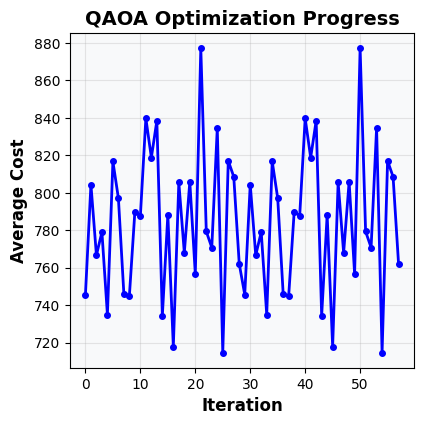

In [45]:
# 시각화
fig = plt.figure(figsize=(16, 10))

# 2x3 그리드 레이아웃
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. 최적화 과정
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(optimization_history['iteration'],
         optimization_history['cost'],
         'b-', linewidth=2, marker='o', markersize=4)
ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Cost', fontsize=12, fontweight='bold')
ax1.set_title('QAOA Optimization Progress', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#f8f9fa')

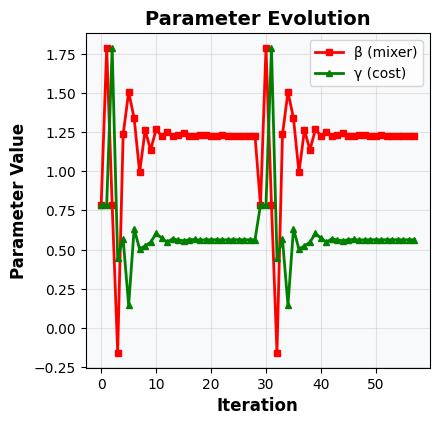

In [46]:
# 시각화
fig = plt.figure(figsize=(16, 10))

# 2. 파라미터 진화
ax2 = fig.add_subplot(gs[0, 1])
betas = [p[0] for p in optimization_history['params']]
gammas = [p[1] for p in optimization_history['params']]
ax2.plot(optimization_history['iteration'], betas,
         'r-', label='β (mixer)', linewidth=2, marker='s', markersize=4)
ax2.plot(optimization_history['iteration'], gammas,
         'g-', label='γ (cost)', linewidth=2, marker='^', markersize=4)
ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax2.set_ylabel('Parameter Value', fontsize=12, fontweight='bold')
ax2.set_title('Parameter Evolution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#f8f9fa')


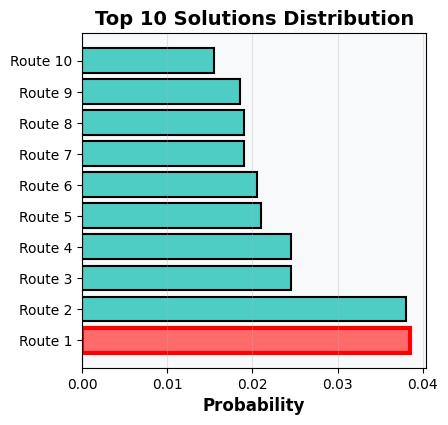

In [47]:
# 시각화
fig = plt.figure(figsize=(16, 10))

# 3. 솔루션 분포 (상위 10개)
ax3 = fig.add_subplot(gs[0, 2])
top_10_routes = sorted_routes[:10]
route_labels = [f"Route {i+1}" for i in range(len(top_10_routes))]
route_probs = [count/len(final_samples) for _, count in top_10_routes]
colors = ['#ff6b6b' if i == 0 else '#4ecdc4' for i in range(len(top_10_routes))]

bars = ax3.barh(route_labels, route_probs, color=colors, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Probability', fontsize=12, fontweight='bold')
ax3.set_title('Top 10 Solutions Distribution', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.set_facecolor('#f8f9fa')

# 최고 솔루션 강조
bars[0].set_edgecolor('red')
bars[0].set_linewidth(3)


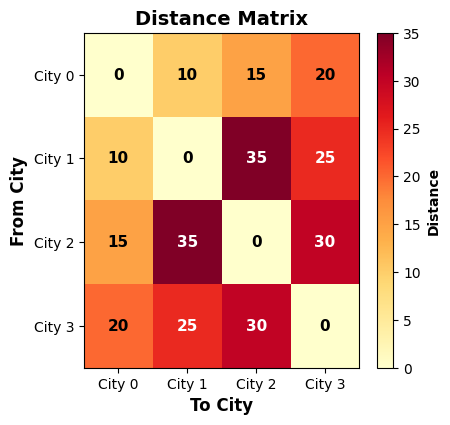

In [48]:
# 시각화
fig = plt.figure(figsize=(16, 10))

# 4. 거리 행렬 히트맵
ax4 = fig.add_subplot(gs[1, 0])
im = ax4.imshow(distance_matrix, cmap='YlOrRd', aspect='auto')
ax4.set_xticks(range(n_cities))
ax4.set_yticks(range(n_cities))
ax4.set_xticklabels([f'City {i}' for i in range(n_cities)])
ax4.set_yticklabels([f'City {i}' for i in range(n_cities)])
ax4.set_xlabel('To City', fontsize=12, fontweight='bold')
ax4.set_ylabel('From City', fontsize=12, fontweight='bold')
ax4.set_title('Distance Matrix', fontsize=14, fontweight='bold')

# 거리 값 표시
for i in range(n_cities):
    for j in range(n_cities):
        text = ax4.text(j, i, int(distance_matrix[i, j]),
                       ha="center", va="center",
                       color="white" if distance_matrix[i, j] > 20 else "black",
                       fontsize=11, fontweight='bold')
    ###for
###for

cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Distance', fontsize=10, fontweight='bold')

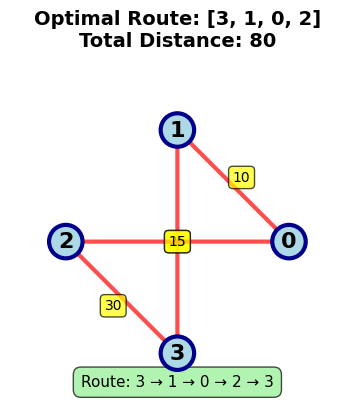

In [49]:
# 시각화
fig = plt.figure(figsize=(16, 10))

# 5. 최적 경로 시각화
ax5 = fig.add_subplot(gs[1, 1:])

if best_route:
    # 도시 위치 (원형 배치)
    angles = np.linspace(0, 2*np.pi, n_cities, endpoint=False)
    city_positions = [(np.cos(a), np.sin(a)) for a in angles]

    # 경로 그리기
    for i in range(len(best_route)):
        city1 = best_route[i]
        city2 = best_route[(i+1) % len(best_route)]

        pos1 = city_positions[city1]
        pos2 = city_positions[city2]

        # 화살표로 경로 표시
        ax5.annotate('', xy=pos2, xytext=pos1,
                    arrowprops=dict(arrowstyle='->', lw=3,
                                  color='red', alpha=0.7))

        # 거리 라벨
        mid_x = (pos1[0] + pos2[0]) / 2
        mid_y = (pos1[1] + pos2[1]) / 2
        distance = distance_matrix[city1][city2]
        ax5.text(mid_x * 1.15, mid_y * 1.15, f'{distance}',
                fontsize=10, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3',
                         facecolor='yellow', alpha=0.7))
    ###for

    # 도시 노드
    for i, pos in enumerate(city_positions):
        circle = plt.Circle(pos, 0.15, color='lightblue',
                          ec='darkblue', linewidth=3, zorder=5)
        ax5.add_patch(circle)
        ax5.text(pos[0], pos[1], f'{i}', fontsize=16,
                ha='center', va='center', fontweight='bold', zorder=6)
    ###for

    ax5.set_xlim(-1.5, 1.5)
    ax5.set_ylim(-1.5, 1.5)
    ax5.set_aspect('equal')
    ax5.axis('off')

    # 제목에 총 거리 표시
    ax5.set_title(f'Optimal Route: {best_route}\n'
                 f'Total Distance: {best_distance}',
                 fontsize=14, fontweight='bold', pad=20)

    # 범례
    ax5.text(0, -1.3, f'Route: {" → ".join(map(str, best_route))} → {best_route[0]}',
            ha='center', fontsize=11,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

else:
    ax5.text(0.5, 0.5, 'No valid route found',
            ha='center', va='center', fontsize=16,
            transform=ax5.transAxes)
    ax5.axis('off')
###if
